Для датасета "winequality-red.csv" провести обработку данных и построить предсказательную модель с использованием функционала pySpark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, isnull, desc_nulls_first, desc, \
    from_unixtime, col, dayofweek, dayofyear, hour, to_date, month
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark = SparkSession(spark)
wine = spark.read.csv("winequality-red.csv",
                      inferSchema="true", 
                      header="true", 
                      sep =';')

wine.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [4]:
#выведем схему датасета
wine.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



Как видно из схемы, в датасете отсутствуют категориальные переменные

In [5]:
#определим наличие NAN значений в датасете

wine.select([count(when(isnan(c), c)).alias(c)\
             for c in wine.columns]).head().asDict() #Смотрим на количество NaN значений

{'fixed acidity': 0,
 'volatile acidity': 0,
 'citric acid': 0,
 'residual sugar': 0,
 'chlorides': 0,
 'free sulfur dioxide': 0,
 'total sulfur dioxide': 0,
 'density': 0,
 'pH': 0,
 'sulphates': 0,
 'alcohol': 0,
 'quality': 0}

То есть пустых значений в нашем датасете нету.

In [6]:
#определим наличие дубликатов. Для этого сначала выведем общее количество записей в датасете
wine.count()

1599

In [7]:
#воспользуемся функцией distinct для удлаения дубликатов и повторно выведем общее количество записей в датасете
wine = wine.distinct()
wine.count()

1359

Таким образом, в датасете было 240 дублирующихся записей. 
Проверив датасет на наличие пустых значений и удаления дубликатов можно переходить к подготовке даннных для построения модели

D:\Olya_work\anaconda3\envs\New_Environment\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<AxesSubplot: >

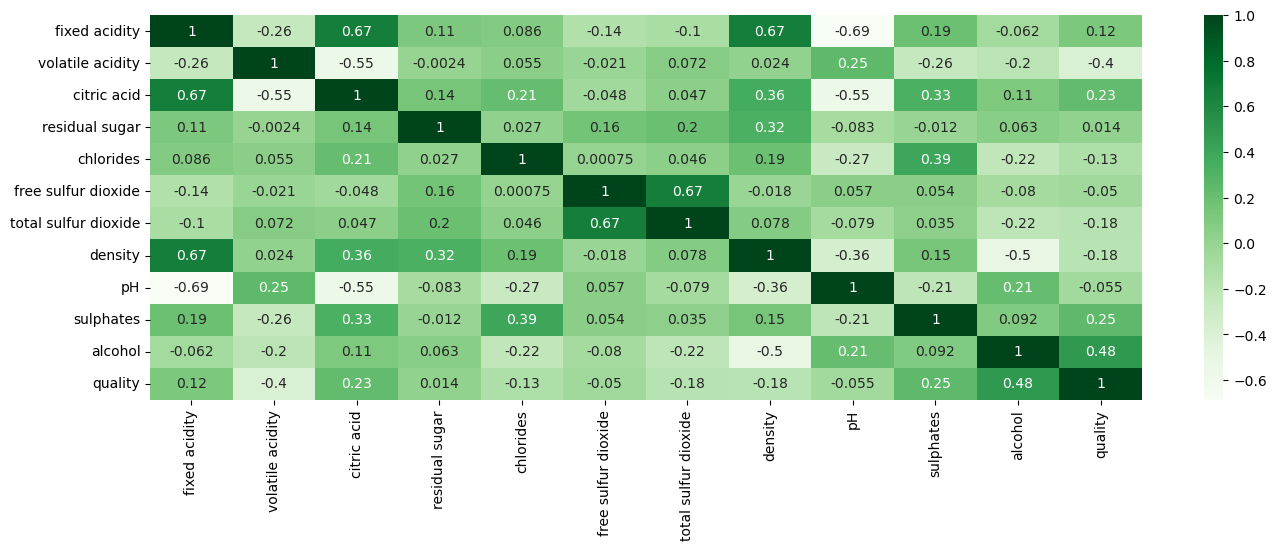

In [8]:
assembler = VectorAssembler(inputCols=wine.columns, outputCol="corr_features")
df = assembler.transform(wine).select("corr_features")

matrix = Correlation.corr(df, "corr_features")
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

plt.figure(figsize=(16,5))  
sns.heatmap(cor_np, 
            xticklabels=wine.columns,
            yticklabels=wine.columns,  
            cmap="Greens", 
            annot=True)

Как видно из матрицы корреляции, целевая переменная имеет прямую зависимость от параметра alcohol(0.48)

Поскольку Spark может обучить модель на преобразованных данных, где предсказываемая колонка является вектором и колонки с признаками тоже — вектор, сначала преобразуем нашу целевую колонку(quality) в вектор

In [9]:
#quality - это зависимая и предсказываемая переменная - метка
stages = []
label_stringIdx = StringIndexer(inputCol = 'quality', outputCol = 'label', handleInvalid = 'keep')
stages += [label_stringIdx]

Поскольку категориальных признаков в данном датасете нету, преобразуем оставшиеся колонки с признаками в один вектор, что можно достичь с помощью VectorAssembler(), который берёт на вход название численных (для этого мы и преобразовали строки в числа в предыдущем шаге) колонок (assemblerInputs) и преобразовываем все колонки в один вектор с именем «features»

In [10]:
numericCols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
               'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH','sulphates',
               'alcohol']
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Subscribed")
stages += [assembler]

Разобьем датасет на тренировочную и тестовую модели

In [11]:
#делим данные на обучающую и тестовую выборки (30% тестовая)
(trainingData, testData) = wine.randomSplit([0.7, 0.3])

#тренируем модель (градиентного регрессионого дерева бустинга)
gbt = GBTRegressor(labelCol="label", featuresCol="Subscribed", maxIter=10)
stages += [gbt]

# задаем план stages для обучения модели 
pipeline = Pipeline(stages=stages)

In [12]:
# тренируем модель
model = pipeline.fit(trainingData)

# делаем предсказания на тестовой выборке
predictions = model.transform(testData)


In [13]:
predictions.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+-------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|label|          Subscribed|         prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+--------------------+-------------------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|   13.1|      4|  3.0|[4.6,0.52,0.15,2....|0.30898184070257606|
|          5.0|            0.38|       0.01|           1.6|    0.048|               26.0|                60.0|0.99084| 3.7|     0.75|   14.0|      6|  1.0|[5.0,0.38,0.01,1....| 1.9658073571780634|
|          5.0|

## RandomForestClassifier

In [14]:
from pyspark.ml.classification import RandomForestClassifier

pipelineModel = pipeline.fit(wine)
df = pipelineModel.transform(wine)
selectedCols = ['label', 'Subscribed'] + numericCols
df = df.select(selectedCols)

train, test = df.randomSplit([0.8, 0.2], seed = 80)

rf = RandomForestClassifier(featuresCol = 'Subscribed', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure")
print('Weighted F-Measure', evaluator.evaluate(predictions))

Weighted F-Measure 0.5564205344298689
